# В качестве агента была взята игра с openAI


In [ ]:
# Будем обращаться к линукс-ядру напрямую с помощью команд на "!"
# Будем устанавливать окружение из пакета Stable Baseline для OpenAI (для того, чтобы можно было использовать движок в колабе)
# Код, представленный в документации разработчика
!apt install swig cmake libopenmpi-dev zlib1g-dev # cmake - сборка - аналог GNU Make, но с другим синтаксисом, libopenmpi-dev распределённые вычисления в кластере для дебиан, zlib1g-dev - сжатие траффика
!pip install stable-baselines==2.5.1 box2d box2d-kengz # устанавливаем непосредственно сам stable baseline и движок box2d

# если убрать " > /dev/null 2>&1" то работа сервера будет выведена на экран, а этой командой перемещаем все в фоновый режим
!pip install gym pyvirtualdisplay > /dev/null 2>&1 # установка пакета для рендера видео
!pip install xvfbwrapper # установка обертки для пакета, который позволит воспроизводить видео в ячейке колаба  
!apt-get update # обновляем все пакеты до новейшей версии, чтобы все пакеты "подружились"
!sudo apt-get install xvfb # установка удаленного сервера, благодаря которому видео будет воспроизводиться в ячейке колаба
!apt-get install xdpyinfo # пакет для вывода процессов, происходящих на сервере

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libopenmpi-dev is already the newest version (2.1.1-8).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 30 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (1,515 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 160980 files and dire

# Импорт библиотек



In [ ]:
import gym # здесь лежат все модели для 
from gym import logger as gymlogger # загрузим библиотеку для изменения параметра вывода ошибок
from gym.wrappers import Monitor # библиотека для обертки видео из хранилища в ячейку
gymlogger.set_level(40) # для правильного отображения ошибок
import numpy as np # библиотека массивов numpy
import random # библиотека для генерации случайных значений
import matplotlib # библиотека для визуализации процессов
import matplotlib.pyplot as plt # библиотека для построения графика
%matplotlib inline
import glob # расширение для использования Unix обозначений при задании пути к файлу
import io # библиотека для работы с потоковыми данными
import base64 # расширение для преобразования в формат base64 (универсальный формат хранения сырых изображений в виде набора электрических сигналов)
from IPython.display import HTML # библиотека для кодирования в код HTML
import time # библиотека для расчета времени обучения

from IPython import display as ipythondisplay # для работы с "сырым" форматом (набор сигналов, а не пиксели)
from pyvirtualdisplay import Display # для создания окна дисплея


In [ ]:
# Создаем объект дисплей, таким образом, симуляцию можно будет наблюдать в колабе
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
'''

Функция, позволяющая записывать видео того,
что происходит в окружении и отображать это в колабе

'''

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#https://github.com/openai/gym/wiki/CartPole-v0


In [ ]:
# Запускаем среду
env = gym.make('CartPole-v1')

https://github.com/openai/gym/wiki/CartPole-v0

In [ ]:
numBots = 100
popul = [] # здесь будет лежать популяция

for i in range(numBots):  
  bot = np.random.random((4,2))
  popul.append(bot)

In [ ]:

env = wrap_env(env) # оборачиваем наше окружения для записи видео
#env.seed(0) # симуляция одного и того же окружения
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 1
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,popul[np.random.randint(0, numBots-1)])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()

# Генетические алгоритмы



In [ ]:
'''
    Функция получения выжившей популяции
        Входные параметры:
        - popul - наша популяция
        - val - текущие значения
        - nsurv - количество выживших
        - reverse - указываем требуемую операцию поиска результата: максимизация или минимизация
'''
def getSurvPopul(
        popul,
        val,
        nsurv,
        reverse
        ):
    newpopul = [] # Двумерный массив для новой популяции

    sval= sorted(val, reverse=reverse) # Сортируем зачения в val в зависимости от параметра reverse
    for i in range(nsurv): # Проходимся по циклу nsurv-раз (в итоге в newpopul запишется nsurv-лучших показателей)
        index = val.index(sval[i]) # Получаем индекс i-того элемента sval в исходном массиве val
        newpopul.append(popul[index]) # В новую папуляцию добавляем элемент из текущей популяции с найденным индексом
    return newpopul, sval # Возвращаем новую популяцию (из nsurv элементов) и сортированный список

'''
    Функция получения родителей
        Входные параметры:
        - curr_popul - текущая популяция
        - nsurv - количество выживших
'''
def getParents(
        curr_popul,
        nsurv
        ):   
    indexp1 = random.randint(0, nsurv - 1) # Случайный индекс первого родителя в диапазоне от 0 до nsurv - 1
    indexp2 = random.randint(0, nsurv - 1) # Случайный индекс второго родителя в диапазоне от 0 до nsurv - 1    
    botp1 = curr_popul[indexp1] # Получаем первого бота-родителя по indexp1
    botp2 = curr_popul[indexp2] # Получаем второго бота-родителя по indexp2 
   
    return botp1,botp2 # Возвращаем обоих полученных ботов

'''
    Функция смешивания (кроссинговера) двух родителей
        Входные параметры:
        - botp1 - первый бот-родитель
        - botp2 - второй бот-родитель
        - j - номер компонента бота
'''

def crossPointFrom2Parents(
        botp1,
        botp2 ,
        mut
        ):
    
    for i in range(botp1.shape[0]):
      for j in range(botp2.shape[1]):

        pindex = np.random.random() # Получаем случайное число в диапазоне от 0 до 1
    
        #Если pindex меньше 0.5, то берем значения от первого бота, иначе от второго
        if pindex < 0.5:
          botp1[i,j] = botp2[i,j]
        if np.random.random() < mut:
          botp1[i,j] += (np.random.random()*2-1)/10
            
    return botp1 # Возвращаем значние бота

    

'''
    Функция расчета вознаграждения за эпизод
        Входные параметры:
        - popul - популяция ботов
'''

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def countValue(
    popul
    ):
  
  action=1  # генерируем первое  действие случайным из пространства действий
                                     # 1 - ничего не делать 
                                     # 0 - push left
                                     # 2 - push right
                                     

  reward_list=[] # здесь будет сумма вознаграждений для каждого эпизода

  for bot in popul: # проходимся по каждому боту в популяции
    #env.seed(0)  # При инициализации среда генерируется случайным образом каждый раз новая,
                 # поэтому ограничим интервал генерации - т.е. будем использовать только одну конкретную среду
    env.reset() # И обновлять окружение
    i=0 
    tmp=0
    done=False
    while done!=True:
      observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
      result = np.dot(observation,bot) # матрично перемножаем бота и вектор наблюдения для предсказания следующего движения
      # prop_list = softmax(result)
      # if np.random.random()<0.5:
      #     action = np.random.randint(1,3)
      # else:
      #   action = np.random.choice([0,1,2], p=prop_list)
      
      action = np.argmax(result)
      #print(action)
      tmp+=reward
    reward_list.append(tmp) # Функция, по которой будет вычисляться "успех текущей симуляции"
    
  return reward_list  

0 0.08156347274780273   [500.0, 327.0, 306.0]
1 0.33614587783813477   [500.0, 500.0, 500.0]
2 0.06726789474487305   [83.0, 79.0, 77.0]
3 0.04984927177429199   [111.0, 110.0, 105.0]
4 0.06485319137573242   [146.0, 141.0, 128.0]
5 0.20520472526550293   [500.0, 489.0, 456.0]
6 0.24524521827697754   [500.0, 500.0, 500.0]
7 0.3283369541168213   [500.0, 500.0, 500.0]
8 0.2288837432861328   [500.0, 478.0, 470.0]
9 0.4769728183746338   [500.0, 500.0, 500.0]
10 0.7486958503723145   [500.0, 500.0, 500.0]
11 0.6507701873779297   [500.0, 500.0, 500.0]
12 0.07442593574523926   [146.0, 83.0, 77.0]
13 0.4809296131134033   [500.0, 500.0, 500.0]
14 0.019643306732177734   [13.0, 13.0, 13.0]
15 0.01769256591796875   [13.0, 12.0, 11.0]
16 0.01853775978088379   [13.0, 13.0, 12.0]
17 0.023576974868774414   [27.0, 27.0, 27.0]
18 0.09493446350097656   [163.0, 158.0, 156.0]
19 0.19891047477722168   [392.0, 295.0, 269.0]
20 0.19702577590942383   [287.0, 262.0, 236.0]
21 0.28308749198913574   [436.0, 420.0, 362.

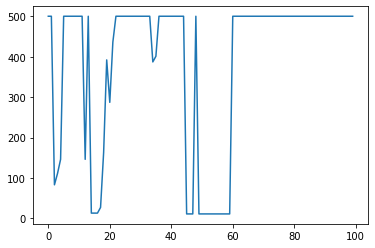

In [ ]:
total=[] # Для построения графика
n = 100 # популяция
nsurv = 20 # количество выживших
nnew = n-nsurv # количество новых
epohs = 100 # количество эпох
mut = 0.5 # коэфициент мутаций
curr_time = time.time()

for it in range(epohs): # создали список списков всех значений по эпохам
  val = countValue(popul) # считаем успех каждого из ботов
  newpopul, sval = getSurvPopul(popul, val, nsurv, 1) # получили популяцию выживших, нас интересует бот с максимальным успехом, поэтому reverse = 1
  print(it, time.time() - curr_time, " ", sval[0:3]) # Выводим время на операцию, среднее значение и 20 лучших ботов  
  total.append(sval[0]) # заносим самого лучшего бота в список для построения графика эволюции
  curr_time = time.time() # Обновляем текущее время

  # проходимся по новой популяции
  for k in range(nnew):

    # вытаскиваем новых родителей
    botp1, botp2 = getParents(newpopul, nsurv) 
        
    newbot = crossPointFrom2Parents(botp1, botp2,mut) # скрещиваем
     
    newpopul.append(newbot) # добавляем бота
  popul = newpopul # вывести список на эпоху
  popul = np.array(popul) # для того, чтобы можно было легко вытащить индексы условием, преобразуем в numpy массив
plt.plot(total)
print(np.mean(total)) 

In [ ]:
val = countValue(popul) # считаем успех каждого из ботов
newpopul, sval = getSurvPopul(popul, val, nsurv, 1) # получили популяцию выживших, нас интересует бот с максимальным успехом, поэтому reverse = 1

In [ ]:
env = wrap_env(env) # оборачиваем наше окружения для записи видео
observation = env.reset() # обнуляем вектор наблюдения
i=0
action = 1
while True:

    env.render() # Рендер окружения
    # В качестве действия будем подавать значения нашего лучшего бота
    observation,reward,done,_ = env.step(action) # остлеживаем все параметры для подсчета функции значения
    result = np.dot(observation,newpopul[0])
    action = np.argmax(result)
    if done: 
      break;
            
env.close()
show_video()